# Inverse kinematic in 3 dimension

QUESTIONS:

-How can I handle boundary consitions?

-Devo fissare un limite per i casi in cui il braccio si blocca e continua a fare iterazioni pur non modificando la posizione?

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
def compute_end_pos(links, theta, alpha):
    pos=np.array([0,0,0,1])
    for i in range(len(links)-1,-1,-1):
        st=np.sin(theta[i])
        ct=np.cos(theta[i])
        sa=np.sin(alpha[i])
        ca=np.cos(alpha[i])
        transf=[[ct, -ca*st, st*sa,  links[i]*(ct-ca*st)],
                [st, ca*ct, -ca*sa,  links[i]*(st+ca*ct)],
                [0,  sa,    ca,      sa*links[i]        ],
                [0,  0,     0,       1                  ]]
        pos=np.dot(transf,pos)
    return pos[:3]

In [5]:
def check_constraints(indiv, vel, constraints_theta, type):
    if constraints_theta is None:
        return indiv
    if type == 'absorb':
        for i in range(len(constraints_theta)):
            if indiv[i]<constraints_theta[i][0]:
                indiv[i]=constraints_theta[i][0]
            elif indiv[i]>constraints_theta[i][1]:
                indiv[i]=constraints_theta[i][1]
            else:
                indiv[i]=indiv[i]+vel[i]
    elif type == 'reflect':
        for i in range(len(constraints_theta)):
            if indiv[i]<constraints_theta[i][0]:
                indiv[i]=constraints_theta[i][0]-vel[i]
            elif indiv[i]>constraints_theta[i][1]:
                indiv[i]=constraints_theta[i][1]-vel[i]
            else:
                indiv[i]=indiv[i]+vel[i]
    elif type == 'damping':
        for i in range(len(constraints_theta)):
            if indiv[i]<constraints_theta[i][0]:
                indiv[i]=constraints_theta[i][0]-random.uniform(0,1)*vel[i]
            elif indiv[i]>constraints_theta[i][1]:
                indiv[i]=constraints_theta[i][1]-random.uniform(0,1)*vel[i]
            else:
                indiv[i]=indiv[i]+vel[i]
    return indiv        

In [6]:
def PSO(links, target, pop_size, max_iter, w, c_soc, c_cog, alpha_values=None, constraints_theta=None, type='absorb'):
    '''
    !!!     CONSTRAINT FOR ALPHA : directly specify ALPHA VALUES        !!!
    !!!     CONSTRAINT FOR THETA : specify CONSTRAINTS for THETA        !!!
    input:
        -links: list of links lengths
        -target: target position
        -pop_size: population size
        -max_iter: maximum number of iterations
        -w: inertia weight
        -c_soc: social component
        -c_cog: cognitive component
        -alpha_values: list of alpha values
        -constraints_theta: list of constraints for theta values

    output:
        -theta_best_hist: list of best theta values for each iteration
        -alpha_best_hist: list of best alpha values for each iteration
        -gbest: best individual found
    '''
    if alpha_values==None:
        dim=len(links)*2
        def update_alpha(i):
            return pop[i][len(links):]
        def update_best_alpha():
            return gbest[len(links):].copy()
    else:
        dim=len(links)
        def update_alpha(i):
            return alpha_values
        def update_best_alpha():
            return alpha_values

        
    if constraints_theta==None:
        pop=np.random.rand(pop_size,dim)*2*np.pi
    else:
        pop=np.zeros((pop_size,dim))
        for i in range(pop_size):
            elem=[random.uniform(constrain[0],constrain[1]) for constrain in constraints_theta]
            pop[i,:]=elem
        
        
    print(pop.shape)
    vel=np.zeros((pop_size,dim))
    pbest=pop.copy()
    pbest_fit=np.zeros(pop_size)
    gbest=pop[0].copy()
    gbest_fit=1e10
    theta_best_hist=[]
    alpha_best_hist=[]

    #initialise pbest and gbest
    for i in range(pop_size):
        theta= pop[i][0:len(links)]
        alpha= update_alpha(i)
        pos=compute_end_pos(links, theta, alpha)
        pbest_fit[i]=np.linalg.norm(pos-target)
        if pbest_fit[i]<gbest_fit:
            gbest=pop[i].copy()
            gbest_fit=pbest_fit[i]

    #main loop
    it=0
    theta_best_hist.append(gbest[0:len(links)].copy())
    alpha_best_hist.append(update_best_alpha())
    while it<max_iter:
        it+=1
        for i in range(pop_size):
            theta= pop[i][0:len(links)]
            alpha= update_alpha(i)
            end_pos = compute_end_pos(links, theta, alpha)
            fit=np.linalg.norm(end_pos-target)

            if fit<pbest_fit[i]:
                pbest[i]=pop[i].copy()
                pbest_fit[i]=fit
                if fit<gbest_fit:
                    gbest=pop[i].copy()
                    gbest_fit=fit
                if fit<1e-3:
                    print(f"Solution found in {it} iteration :)")
                    print(f"position: {end_pos}")
                    print(f"fit: {fit}")
                    print(f"best_pop: {pop[i]}")
                    print(f"gbest: {gbest}")
                    theta_best_hist.append(gbest[0:len(links)].copy())
                    alpha_best_hist.append(update_best_alpha())
                    return theta_best_hist, alpha_best_hist, gbest
                
            vel[i]=w*vel[i]+c_soc*np.random.rand()*(gbest-pop[i])+c_cog*np.random.rand()*(pbest[i]-pop[i])
            pop[i]+=vel[i] 
            pop[i]=check_constraints(pop[i], vel[i], constraints_theta, type)


        theta_best_hist.append(gbest[0:len(links)].copy())
        alpha_best_hist.append(update_best_alpha())
        
    print(f"maximum iterations reached") 
    end_pos=compute_end_pos(links, gbest[0:len(links)], update_best_alpha())   
    print(f"position: {end_pos}")
    print(f"fit: {np.linalg.norm(end_pos-target)}")
    print(f"gbest: {gbest}")
    return theta_best_hist,alpha_best_hist, gbest

 ### Display

In [7]:
def DisplayNlinkarm(links, theta, alpha):
    #plot arm
    trasf=np.eye(4)
    x=[0]
    y=[0]
    z=[0]
    for i in range(len(links)):
        st=np.sin(theta[i])
        ct=np.cos(theta[i])
        sa=np.sin(alpha[i])
        ca=np.cos(alpha[i])
        new_trasf=[[ct, -ca*st, st*sa,  links[i]*(ct-ca*st)],
                   [st, ca*ct, -ca*sa,  links[i]*(st+ca*ct)],
                   [0,  sa,    ca,      sa*links[i]        ],
                   [0,  0,     0,       1                  ]]
        trasf=np.dot(trasf,new_trasf)
        x.append(np.dot(trasf,[0,0,0,1])[0])
        y.append(np.dot(trasf,[0,0,0,1])[1])
        z.append(np.dot(trasf,[0,0,0,1])[2])

    #plot in 3D space
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(x, y, z)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

In [16]:
def Display_animated(links,theta, alpha, target, title, jump=1):
    fig = plt.figure()
    #plot in 3D space
    ax = fig.add_subplot(projection='3d')
    
    line = ax.plot([], [], [])

    plt.plot(target[0], target[1], target[2], 'ro')

    def animate(i, line):
        trasf=np.eye(4)
        x=[0]
        y=[0]
        z=[0]
        for j in range(len(links)):
            st=np.sin(theta[i*jump][j])
            ct=np.cos(theta[i*jump][j])
            sa=np.sin(alpha[i*jump][j])
            ca=np.cos(alpha[i*jump][j])
            new_trasf=[[ct, -ca*st, st*sa,  links[j]*(ct-ca*st)],
                    [st, ca*ct, -ca*sa,  links[j]*(st+ca*ct)],
                    [0,  sa,    ca,      sa*links[j]        ],
                    [0,  0,     0,       1                  ]]
            trasf=np.dot(trasf,new_trasf)
            x.append(np.dot(trasf,[0,0,0,1])[0])
            y.append(np.dot(trasf,[0,0,0,1])[1])
            z.append(np.dot(trasf,[0,0,0,1])[2])
        line.set_data(x,y)
        line.set_3d_properties(z)
        if i==len(theta)/jump-1:
            plt.title('Iteration: '+str(i*jump)+" Converged")
        else:
            plt.title('Iteration: '+str(i*jump))
        return line,

    anim = animation.FuncAnimation(fig, animate,
                                frames=len(theta)//jump, fargs=(line), interval=1000)
    anim.save(title+'.gif', fps=2)
    plt.show()
    plt.close()



## Test

### N link robotic arm NO CONSTRAINT

In [9]:
theta, alpha, gbest = PSO([2,3,4], [ 2.9330127 ,  1.15192379, 10.06217783], 100, 5000, 0.5, 1, 1)

(100, 6)
Solution found in 25 iteration :)
position: [ 2.93302509  1.15151999 10.06229504]
fit: 0.00042064942420561084
best_pop: [3.66118732 2.93549006 1.56912052 1.57157752 3.76764193 3.89573712]
gbest: [3.66118732 2.93549006 1.56912052 1.57157752 3.76764193 3.89573712]


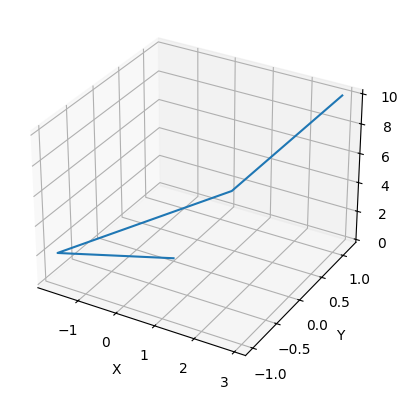

In [10]:
DisplayNlinkarm([2,3,4], gbest[:3], gbest[3:])

MovieWriter ffmpeg unavailable; using Pillow instead.


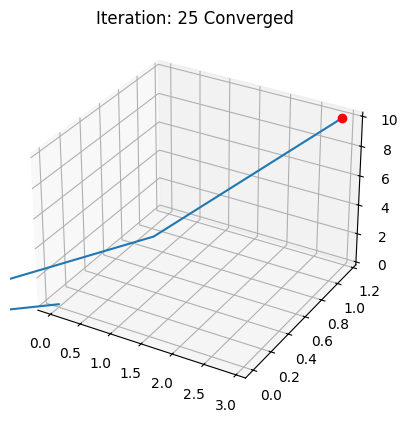

In [17]:
Display_animated([2,3,4], theta, alpha, [ 2.9330127 ,  1.15192379, 10.06217783], 'no_constraints3d')

### WITH CONSTRAINT

In [22]:
links=[2,3,4]
target=[ 2.9330127 ,  1.15192379, 10.06217783]
pop_size=100
max_iter=5000
w=0.5
c_soc=1
c_cog=1
alpha_values=[np.pi/2, np.pi/2, np.pi/2]

In [23]:
theta, alpha, gbest = PSO(links, target, pop_size, max_iter, w, c_soc, c_cog, alpha_values=alpha_values, type='reflect')

(100, 3)
maximum iterations reached
position: [2.81898031 1.99389993 8.0817899 ]
fit: 2.1549625374627017
gbest: [1.74160769 2.08738353 6.33561472]


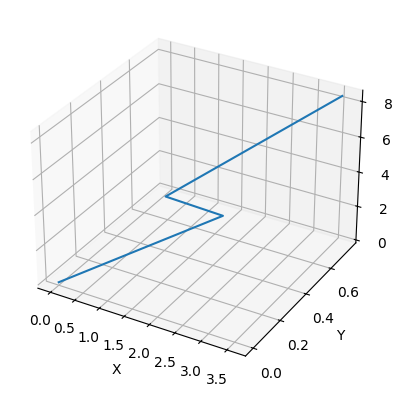

In [12]:
DisplayNlinkarm(links, gbest[:3], alpha_values)

MovieWriter ffmpeg unavailable; using Pillow instead.


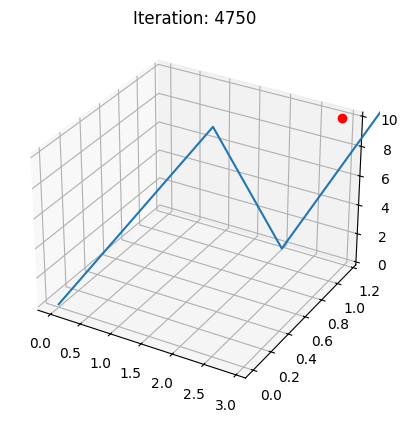

In [24]:
Display_animated(links, theta, alpha, target, 'constraint_test',jump=250)

In [26]:
links=[0.5,0.2,0.25,0.3,0.2,0.2,0.1]
alpha_values=[-np.pi/2,np.pi/2,-np.pi/2,np.pi/2,-np.pi/2,0,0]
target=compute_end_pos(links, [np.pi/4,0,np.pi/4,0,np.pi/4,0,0], alpha_values)
pop_size=100
max_iter=1000
w=0.5
c_soc=1
c_cog=1

In [29]:
theta, alpha, gbest = PSO(links, target, pop_size, max_iter, w, c_soc, c_cog, alpha_values=alpha_values, type='absorb')

(100, 7)
Solution found in 13 iteration :)
position: [ 0.0265748   0.61916506 -0.50049922]
fit: 0.0009724050868487282
best_pop: [1.51012485 3.14573986 3.52796283 5.514173   0.77859371 3.06444558
 2.06659832]
gbest: [1.51012485 3.14573986 3.52796283 5.514173   0.77859371 3.06444558
 2.06659832]


MovieWriter ffmpeg unavailable; using Pillow instead.


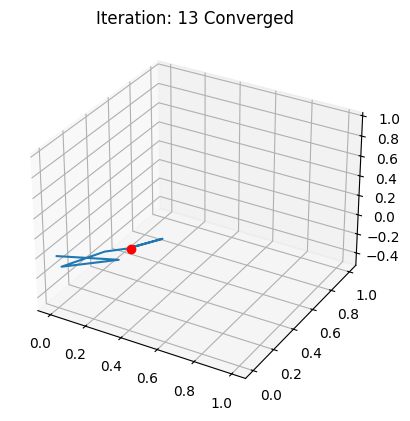

In [30]:
Display_animated(links, theta, alpha, target, '7linkarm_abs',jump=1)